# Simple GNN Inference Pipeline

Basic functions for predicting next frame particle positions.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [45]:
class ParticleDynamicsGNN(MessagePassing):
    """Graph Neural Network for predicting particle dynamics in SPH simulations"""
    
    def __init__(self, in_channels, hidden_channels=64, num_layers=10, dropout=0.1):
        super().__init__(aggr='add')
        
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Input embedding
        self.input_embedding = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Message passing layers
        self.message_mlps = nn.ModuleList()
        self.update_mlps = nn.ModuleList()
        
        for _ in range(num_layers):
            # Message MLP
            message_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.message_mlps.append(message_mlp)
            
            # Update MLP
            update_mlp = nn.Sequential(
                nn.Linear(2 * hidden_channels, hidden_channels),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_channels, hidden_channels)
            )
            self.update_mlps.append(update_mlp)
        
        # Output layer for position prediction
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels // 2, 2)  # Predict 2D position
        )
        
        # Skip connections
        self.skip_connections = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels) for _ in range(num_layers)
        ])
        
    def forward(self, x, edge_index, batch=None):
        # Input embedding
        h = self.input_embedding(x)
        
        # Store for skip connections
        residual = h
        
        # Message passing layers
        for i in range(self.num_layers):
            h_new = self.propagate(edge_index, x=h, layer_idx=i)
            
            # Skip connection
            if i > 0:
                h_new = h_new + self.skip_connections[i](residual)
            
            h = h_new
            
            # Update residual every 2 layers
            if i % 2 == 1:
                residual = h
        
        # Output layer
        out = self.output_layer(h)
        
        return out
    
    def message(self, x_i, x_j, layer_idx):
        # x_i: features of target nodes
        # x_j: features of source nodes
        
        # Concatenate source and target features
        msg_input = torch.cat([x_i, x_j], dim=1)
        
        # Apply message MLP 
        msg = self.message_mlps[layer_idx](msg_input)
        
        return msg
    
    def update(self, aggr_out, x, layer_idx):
        # aggr_out: aggregated messages
        # x: current node features
        
        # Concatenate current features with aggregated messages
        update_input = torch.cat([x, aggr_out], dim=1)
        
        # Apply update MLP
        updated = self.update_mlps[layer_idx](update_input)
        
        return updated
    
    def propagate(self, edge_index, x, layer_idx):
        # Custom propagate to pass layer index
        
        # Compute messages
        row, col = edge_index
        x_i = x[row]
        x_j = x[col]
        
        msg = self.message(x_i, x_j, layer_idx)
        
        # Aggregate messages
        aggr_out = torch.zeros_like(x)
        aggr_out.index_add_(0, row, msg)
        
        # Update nodes
        out = self.update(aggr_out, x, layer_idx)
        
        return out

In [46]:
def load_dataset(filepath, max_episodes=None, skip_timesteps=1):
    """Load SPH dataset from H5 file
    
    Args:
        filepath: Path to H5 file
        max_episodes: Maximum number of episodes to load (for testing)
        skip_timesteps: Load every N timesteps to reduce memory usage
    
    Returns:
        positions: (episodes, timesteps, particles, 2)
        particle_types: (episodes, particles)
    """
    with h5py.File(filepath, 'r') as f:
        episodes = sorted(list(f.keys()))
        if max_episodes:
            episodes = episodes[:max_episodes]
        
        print(f"Loading {len(episodes)} episodes from {filepath}")
        
        all_positions = []
        all_particle_types = []
        
        for i, episode_id in enumerate(episodes):
            if i % 10 == 0:
                print(f"  Loading episode {i+1}/{len(episodes)}...")
                
            # Load position data with optional timestep skipping
            positions = f[f'{episode_id}/position'][::skip_timesteps]
            particle_types = f[f'{episode_id}/particle_type'][:]
            
            all_positions.append(torch.tensor(positions, dtype=torch.float32))
            all_particle_types.append(torch.tensor(particle_types, dtype=torch.long))
            
        # Stack all episodes
        positions = torch.stack(all_positions)
        particle_types = torch.stack(all_particle_types)
        
        print(f"Final shape - Positions: {positions.shape}, Types: {particle_types.shape}")
        return positions, particle_types

In [47]:
def build_graph(positions, radius=0.08, max_neighbors=20):
    """Build graph connectivity from particle positions using spatial partitioning"""
    n_particles = positions.size(0)
    
    # Step 1: Set up spatial grid
    # Determine grid cell size based on interaction radius
    cell_size = radius
    
    # Find bounds of the space
    min_x, min_y = positions[:, 0].min().item(), positions[:, 1].min().item()
    max_x, max_y = positions[:, 0].max().item(), positions[:, 1].max().item()
    
    # Add small padding to avoid edge issues
    padding = cell_size * 0.01
    min_x -= padding
    min_y -= padding
    max_x += padding
    max_y += padding
    
    # Calculate grid dimensions
    grid_width = int((max_x - min_x) / cell_size) + 1
    grid_height = int((max_y - min_y) / cell_size) + 1
    
    # Step 2: Assign particles to grid cells
    # Calculate cell indices for each particle
    cell_x = ((positions[:, 0] - min_x) / cell_size).long()
    cell_y = ((positions[:, 1] - min_y) / cell_size).long()
    cell_indices = cell_y * grid_width + cell_x
    
    # Create a dictionary mapping cell indices to particle indices
    grid_cells = {}
    for particle_idx, cell_idx in enumerate(cell_indices):
        cell_idx = cell_idx.item()  # Convert tensor to value
        if cell_idx not in grid_cells:
            grid_cells[cell_idx] = []
        grid_cells[cell_idx].append(particle_idx)
    
    # Step 3: Find neighbors efficiently
    edge_list = []
    
    for i in range(n_particles):
        # Get the cell of this particle
        cell_idx_i = cell_indices[i].item()
        cell_x_i = cell_idx_i % grid_width
        cell_y_i = cell_idx_i // grid_width
        
        # Collect neighbors
        neighbors = []
        
        # Check the 9 neighboring cells (3x3 grid centered on particle's cell)
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                neighbor_x = cell_x_i + dx
                neighbor_y = cell_y_i + dy
                
                # Skip cells that are outside the grid
                if (neighbor_x < 0 or neighbor_x >= grid_width or
                    neighbor_y < 0 or neighbor_y >= grid_height):
                    continue
                
                neighbor_cell_idx = neighbor_y * grid_width + neighbor_x
                
                # Get particles in this neighboring cell
                neighbor_particles = grid_cells.get(neighbor_cell_idx, [])
                
                for j in neighbor_particles:
                    # Skip self connections
                    if i == j:
                        continue
                    
                    # Calculate actual distance
                    dist = torch.norm(positions[i] - positions[j]).item()
                    
                    # Check if within radius
                    if dist <= radius:
                        neighbors.append((j, dist))
        
        # Limit number of neighbors if needed
        if max_neighbors is not None and len(neighbors) > max_neighbors:
            neighbors.sort(key=lambda x: x[1])  # Sort by distance
            neighbors = neighbors[:max_neighbors]
        
        # Add edges
        for j, _ in neighbors:
            edge_list.append([i, j])
    
    # Convert edge list to tensor
    if edge_list:  # Check if we found any edges
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    else:
        # Return empty edge index
        edge_index = torch.zeros((2, 0), dtype=torch.long)
    
    return edge_index

In [48]:
def prepare_data(positions, particle_types, timestep_idx, target_positions=None):
    """Create complete graph data structure like in training pipeline
    
    Args:
        positions: (N, 2) current positions
        particle_types: (N,) particle types
        timestep_idx: Current timestep index
        target_positions: (N, 2) target positions for next timestep (optional)
    
    Returns:
        Data object for PyTorch Geometric
    """
    # Node features: [x, y, particle_type_one_hot, timestep_normalized]
    # CRITICAL: Use exactly the same feature format as training pipeline
    # Training used 2 particle types (fluid vs boundary), so force num_classes=2
    type_one_hot = F.one_hot(particle_types, num_classes=2).float()
    
    # Normalize timestep
    timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    
    # Combine features: [x, y, type0, type1, timestep] = 5 features total
    node_features = torch.cat([positions, type_one_hot, timestep_feature], dim=1)
    
    # Build graph connectivity
    edge_index = build_graph(positions, radius=0.08)
    
    # Create PyTorch Geometric Data object
    data = Data(x=node_features, edge_index=edge_index)
    
    # Verify feature count matches training (should be 5)
    print(f"Created features with shape: {node_features.shape} (expecting 5 features)")
    
    if target_positions is not None:
        data.y = target_positions
    
    return data

In [49]:
def load_model(model_path, device, input_dim=5):
    """Load best model checkpoint and return ready-to-use model"""
    checkpoint = torch.load(model_path, map_location=device)
    
    print(f"Loading best model checkpoint from {model_path}")
    
    # Use configuration that matches your training pipeline
    model_config = {
        'in_channels': input_dim,
        'hidden_channels': 128,  # From your training pipeline
        'num_layers': 15,         # From your training pipeline
        'dropout': 0.15          # From your training pipeline
    }
    
    # Instantiate model
    model = ParticleDynamicsGNN(**model_config).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model instantiated with config: {model_config}")
    print(f"Loaded from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"Best validation loss: {checkpoint.get('valid_loss', 'unknown')}")
    
    model.eval()  # Set to evaluation mode
    print(f"Model ready for inference on {device}")
    
    return model

## Real Usage Example

Here's how to run inference with your trained model and test data:

In [50]:
def visualize_single_prediction_fixed(model, test_loader, device, sample_idx=None):
    """Visualize a single prediction showing true next and predicted next states"""
    
    model.eval()
    particle_size = 20;
    
    # Get all test data first
    all_batches = []
    for batch in test_loader:
        all_batches.append(batch)
    
    # Select random sample if not specified
    if sample_idx is None:
        sample_idx = 50
    
    # Get the selected batch
    sample_batch = all_batches[sample_idx].to(device)
    
    with torch.no_grad():
        # Make prediction
        pred_positions = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
    
    # Extract data
    current_positions = sample_batch.x[:, :2].cpu()  # Current positions (x, y)
    true_next_positions = sample_batch.y.cpu()       # True next positions
    pred_next_positions = pred_positions.cpu()       # Predicted next positions
    particle_types = sample_batch.x[:, 2:-1].cpu()   # Particle type features
    
    # Get particle type for coloring
    if particle_types.shape[1] > 1:
        particle_colors = particle_types[:, 0]  # Use first type indicator
    else:
        particle_colors = torch.zeros(len(current_positions))
    
    # Create visualization with only 2 plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot true next state
    ax1 = axes[0]
    scatter1 = ax1.scatter(true_next_positions[:, 0], true_next_positions[:, 1], 
                          c=particle_colors, s=particle_size, alpha=0.7, 
                          cmap='viridis', edgecolor='black', linewidth=0.5,
                          vmin=particle_colors.min(), vmax=particle_colors.max())
    ax1.set_title('True Next State', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')
    
    # Plot predicted next state
    ax2 = axes[1]
    scatter2 = ax2.scatter(pred_next_positions[:, 0], pred_next_positions[:, 1], 
                          c=particle_colors, s=particle_size, alpha=0.7, 
                          cmap='viridis', edgecolor='black', linewidth=0.5,
                          vmin=particle_colors.min(), vmax=particle_colors.max())
    ax2.set_title('Predicted Next State', fontsize=14, fontweight='bold')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    ax2.grid(True, alpha=0.3)
    ax2.axis('equal')
    
    # Add colorbar for particle types
    cbar = plt.colorbar(scatter1, ax=axes, orientation='horizontal', 
                       pad=0.1, fraction=0.05, aspect=30)
    cbar.set_label('Particle Type', fontsize=12)
    
    # Calculate and display metrics
    error = torch.norm(pred_next_positions - true_next_positions, dim=1)
    mean_error = error.mean().item()
    max_error = error.max().item()
    
    # plt.suptitle(f'Sample {sample_idx} - Mean Error: {mean_error:.4f}, Max Error: {max_error:.4f}', 
    #             fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # # Print additional statistics
    # print(f"\nSample {sample_idx} Statistics:")
    # print(f"Number of particles: {len(current_positions)}")
    # print(f"Mean prediction error: {mean_error:.6f}")
    # print(f"Max prediction error: {max_error:.6f}")
    # print(f"Standard deviation of error: {error.std().item():.6f}")
    # print(f"Position range - X: [{true_next_positions[:, 0].min():.3f}, {true_next_positions[:, 0].max():.3f}]")
    # print(f"Position range - Y: [{true_next_positions[:, 1].min():.3f}, {true_next_positions[:, 1].max():.3f}]")
    
    return {
        'sample_idx': sample_idx,
        'current_positions': current_positions,
        'true_next_positions': true_next_positions,
        'pred_next_positions': pred_next_positions,
        'errors': error,
        'mean_error': mean_error,
        'max_error': max_error
    }

In [51]:
def prepare_data_with_subsampling(positions, particle_types, timestep_idx, target_positions=None, max_particles=1000):
    """Create graph data with particle subsampling - keep all Type 1, subsample Type 0"""
    
    if len(positions) > max_particles:
        # Separate fluid (Type 0) and boundary (Type 1) particles
        fluid_indices = torch.where(particle_types == 0)[0]
        boundary_indices = torch.where(particle_types == 1)[0]
        
        # Keep ALL boundary particles (Type 1)
        n_boundary = len(boundary_indices)
        n_fluid = max_particles - n_boundary
        
        # Make sure we don't try to sample more fluid particles than available
        n_fluid = min(n_fluid, len(fluid_indices))
        
        # print(f"Keeping all {n_boundary} boundary particles, sampling {n_fluid} fluid particles from {len(fluid_indices)} available")
        
        # Sample fluid particles randomly
        selected_fluid = fluid_indices[torch.randperm(len(fluid_indices))[:n_fluid]]
        
        # Combine indices
        indices = torch.cat([selected_fluid, boundary_indices])
        
        positions = positions[indices]
        particle_types = particle_types[indices]
        if target_positions is not None:
            target_positions = target_positions[indices]
    
    # Continue with normal processing
    type_one_hot = F.one_hot(particle_types, num_classes=2).float()
    timestep_feature = torch.full((len(positions), 1), timestep_idx / 100.0)
    node_features = torch.cat([positions, type_one_hot, timestep_feature], dim=1)
    edge_index = build_graph(positions, radius=0.08)
    data = Data(x=node_features, edge_index=edge_index)
    
    # print(f"Created features with shape: {node_features.shape} (subsampled from original)")
    
    if target_positions is not None:
        data.y = target_positions
    
    return data

## Create data list

USING FIXED VISUALIZATION FUNCTION - IMAGES ONLY
Loading dataset and model...
Loading 3 episodes from /Volumes/Meida/01-CodeLab/01-personal-project/GNN/2D_DAM_5740_20kevery100/test.h5
  Loading episode 1/3...
Final shape - Positions: torch.Size([3, 401, 5740, 2]), Types: torch.Size([3, 5740])
Loading best model checkpoint from /Volumes/Meida/01-CodeLab/01-personal-project/GNN/models/dam_gnn_model_15.pth
Model instantiated with config: {'in_channels': 5, 'hidden_channels': 128, 'num_layers': 15, 'dropout': 0.15}
Loaded from epoch 5
Best validation loss: 0.0018061674199998379
Model ready for inference on mps
Creating test data loader...
Running visualization for sample 0...


/var/folders/nh/szgrk_lj0p7c5cp5vmsqjf180000gn/T/ipykernel_83595/1592033364.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


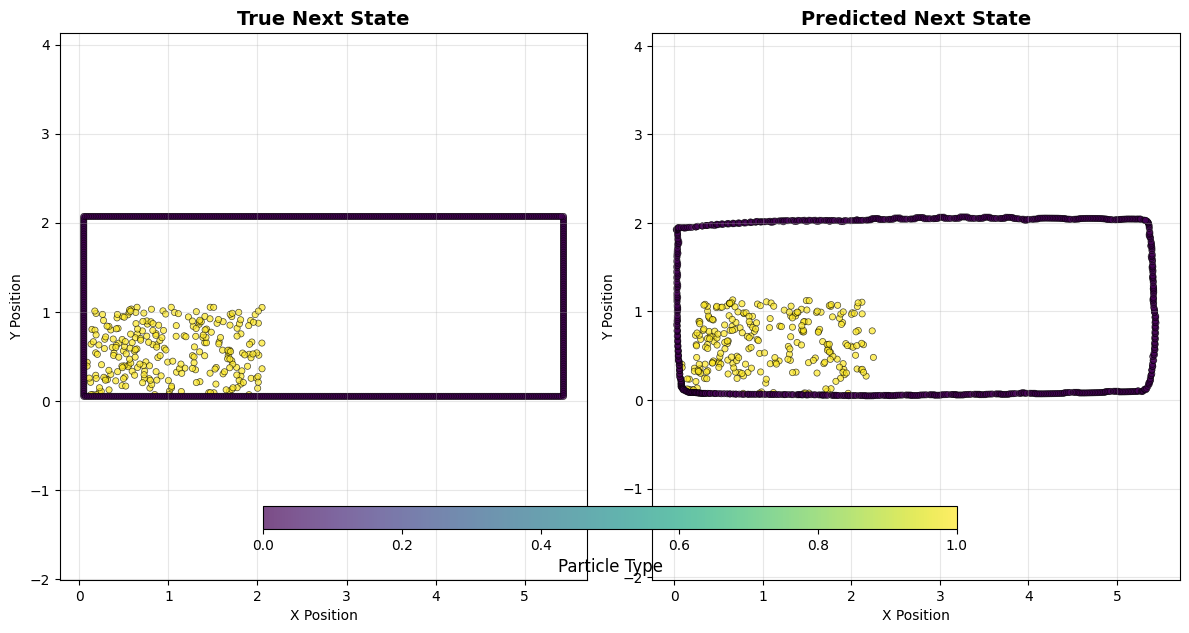

✅ Completed visualization 1/1


In [52]:
# Usage Example for visualize_single_prediction_fixed function - Images Only
print("=" * 60)
print("USING FIXED VISUALIZATION FUNCTION - IMAGES ONLY")
print("=" * 60)
total_frame = 60
max_particles_per_frame = 1000
try:
    # Setup paths
    model_path = '/Volumes/Meida/01-CodeLab/01-personal-project/GNN/models/dam_gnn_model_15.pth'
    data_path = '/Volumes/Meida/01-CodeLab/01-personal-project/GNN/2D_DAM_5740_20kevery100/test.h5'
    
    print("Loading dataset and model...")
    
    # Load dataset
    positions, particle_types = load_dataset(data_path, max_episodes=3, skip_timesteps=1)
    
    # Load model
    model = load_model(model_path, device, input_dim=5)
    
    print("Creating test data loader...")
    
    # Create test data list for the visualization function
    test_data_list = []
    for episode in range(1):
        for t in range(min(total_frame, positions.shape[1] - 1)):  # First 20 timesteps per episode
            current_pos = positions[episode, t]
            target_pos = positions[episode, t + 1]
            # CHANGE THIS LINE: Use subsampling instead of prepare_data
            data = prepare_data_with_subsampling(
                current_pos, particle_types[episode], t, target_pos, 
                max_particles=max_particles_per_frame
            )
            test_data_list.append(data)
    
    # Create data loader (required by the visualization function)
    from torch_geometric.data import DataLoader
    test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False)
    
    # print(f"Created test loader with {len(test_data_list)} samples\n")

    for i in range(1):
        print(f"Running visualization for sample {i}...")
        result = visualize_single_prediction_fixed(model, test_loader, device, sample_idx=i)
        print(f"✅ Completed visualization {i+1}/1")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

## Create animation 

In [53]:
# # Create GIF from the 20 predictions
# import imageio
# from io import BytesIO

# print("Creating GIF from 20 predictions...")
# try:
#     # First, get all batches from the test loader
#     all_batches = []
#     for batch in test_loader:
#         all_batches.append(batch)
    
#     frames = []
    
#     for i in range(total_frame):
#         print(f"Processing frame {i+1}/{total_frame}")
        
#         # Get the same data as your visualization
#         sample_batch = all_batches[i].to(device)
        
#         with torch.no_grad():
#             pred_positions = model(sample_batch.x, sample_batch.edge_index, sample_batch.batch)
        
#         # Extract data (same as your visualization function)
#         true_next_positions = sample_batch.y.cpu()
#         pred_next_positions = pred_positions.cpu()
#         particle_types = sample_batch.x[:, 2:-1].cpu()
        
#         # Get particle colors
#         if particle_types.shape[1] > 1:
#             particle_colors = particle_types[:, 0]
#         else:
#             particle_colors = torch.zeros(len(true_next_positions))
        
#         # Create the same visualization as your function
#         fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
#         # True next state
#         scatter1 = axes[0].scatter(true_next_positions[:, 0], true_next_positions[:, 1], 
#                                   c=particle_colors, s=20, alpha=0.7, 
#                                   cmap='viridis', edgecolor='black', linewidth=0.5,
#                                   vmin=particle_colors.min(), vmax=particle_colors.max())
#         axes[0].set_title(f'True Next State (Frame {i})', fontsize=14, fontweight='bold')
#         axes[0].set_xlabel('X Position')
#         axes[0].set_ylabel('Y Position')
#         axes[0].grid(True, alpha=0.3)
#         axes[0].axis('equal')
        
#         # Predicted next state
#         scatter2 = axes[1].scatter(pred_next_positions[:, 0], pred_next_positions[:, 1], 
#                                   c=particle_colors, s=20, alpha=0.7, 
#                                   cmap='viridis', edgecolor='black', linewidth=0.5,
#                                   vmin=particle_colors.min(), vmax=particle_colors.max())
#         axes[1].set_title(f'Predicted Next State (Frame {i})', fontsize=14, fontweight='bold')
#         axes[1].set_xlabel('X Position')
#         axes[1].set_ylabel('Y Position')
#         axes[1].grid(True, alpha=0.3)
#         axes[1].axis('equal')
        
#         # Add colorbar
#         cbar = plt.colorbar(scatter1, ax=axes, orientation='horizontal', 
#                            pad=0.1, fraction=0.05, aspect=30)
#         cbar.set_label('Particle Type', fontsize=12)
        
#         plt.tight_layout()
        
#         # Save frame to buffer
#         buf = BytesIO()
#         plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
#         buf.seek(0)
#         frames.append(imageio.imread(buf))
#         plt.close()  # Close to save memory
    
#     # Create GIF
#     gif_path = 'dam_simulation_predictions.gif'
#     imageio.mimsave(gif_path, frames, duration=0.8, loop=0)
#     print(f"✅ GIF saved as '{gif_path}'")
#     print(f"📊 Created animation with {len(frames)} frames")
    
# except Exception as e:
#     print(f"❌ Error creating GIF: {e}")
#     import traceback
#     traceback.print_exc()

## Collecting stats

In [54]:
import time
import psutil
import gc
from typing import Dict, List

def collect_episode_inference_statistics(model, positions, particle_types, episode_idx, device, max_particles=1000, max_timesteps=None) -> Dict:
    """
    Collect inference statistics for one complete episode (sequential timesteps)
    
    Args:
        model: Trained GNN model
        positions: Full position data (episodes, timesteps, particles, 2)
        particle_types: Particle type data (episodes, particles)
        episode_idx: Which episode to test (0-based)
        device: torch device (cpu/mps/cuda)
        max_particles: Maximum particles per frame (for subsampling)
        max_timesteps: Maximum timesteps to process (None = all)
    
    Returns:
        Dictionary with all statistics
    """
    model.eval()
    
    # Get episode data
    episode_positions = positions[episode_idx]  # (timesteps, particles, 2)
    episode_particle_types = particle_types[episode_idx]  # (particles,)
    
    num_timesteps = episode_positions.shape[0] - 1  # -1 because we predict next frame
    if max_timesteps:
        num_timesteps = min(num_timesteps, max_timesteps)
    
    print(f"Processing episode {episode_idx} with {num_timesteps} timesteps...")
    print(f"Original particles per frame: {episode_positions.shape[1]}")
    print(f"Max particles per frame: {max_particles}")
    
    # Initialize tracking variables
    total_mae = 0.0
    total_mse = 0.0
    total_samples = 0
    total_inference_time = 0.0
    peak_memory_mb = 0.0
    individual_errors = []
    timestep_times = []
    
    # Get baseline memory
    gc.collect()
    if device.type == 'mps':
        torch.mps.empty_cache()
    elif device.type == 'cuda':
        torch.cuda.empty_cache()
    
    process = psutil.Process()
    baseline_memory = process.memory_info().rss / 1024 / 1024  # MB
    
    print(f"Starting episode inference statistics collection...")
    print(f"Baseline memory usage: {baseline_memory:.2f} MB")
    print(f"Device: {device}")
    
    # Process each timestep in the episode
    with torch.no_grad():
        for t in range(num_timesteps):
            if t % 10 == 0:
                print(f"  Processing timestep {t+1}/{num_timesteps}...")
            
            # Get current and next positions
            current_pos = episode_positions[t]
            target_pos = episode_positions[t + 1]
            
            # Prepare data with subsampling
            data = prepare_data_with_subsampling(
                current_pos, episode_particle_types, t, target_pos, 
                max_particles=max_particles
            )
            
            # Move to device
            data = data.to(device)
            
            # Track memory before inference
            current_memory = process.memory_info().rss / 1024 / 1024
            peak_memory_mb = max(peak_memory_mb, current_memory)
            
            # Time the inference
            start_time = time.time()
            
            # Forward pass
            predictions = model(data.x, data.edge_index, data.batch)
            
            # Ensure computation is complete (important for MPS)
            if device.type == 'mps':
                torch.mps.synchronize()
            elif device.type == 'cuda':
                torch.cuda.synchronize()
            
            end_time = time.time()
            inference_time = end_time - start_time
            total_inference_time += inference_time
            timestep_times.append(inference_time)
            
            # Calculate errors
            true_positions = data.y.cpu()
            pred_positions = predictions.cpu()
            
            # MAE (Mean Absolute Error)
            mae = torch.mean(torch.abs(pred_positions - true_positions)).item()
            total_mae += mae
            
            # MSE (Mean Squared Error) 
            mse = torch.mean((pred_positions - true_positions) ** 2).item()
            total_mse += mse
            
            # Store individual errors for this timestep
            timestep_errors = torch.norm(pred_positions - true_positions, dim=1)
            individual_errors.extend(timestep_errors.tolist())
            
            total_samples += 1
            
            # Track peak memory after inference
            current_memory = process.memory_info().rss / 1024 / 1024
            peak_memory_mb = max(peak_memory_mb, current_memory)
    
    # Calculate final statistics
    avg_mae = total_mae / total_samples
    avg_mse = total_mse / total_samples
    rmse = (avg_mse) ** 0.5
    avg_time_per_step = total_inference_time / total_samples
    total_time_seconds = total_inference_time
    total_time_minutes = total_time_seconds / 60.0
    memory_overhead = peak_memory_mb - baseline_memory
    
    # Additional statistics
    individual_errors = torch.tensor(individual_errors)
    max_error = individual_errors.max().item()
    min_error = individual_errors.min().item()
    std_error = individual_errors.std().item()
    median_error = individual_errors.median().item()
    
    # Timing statistics
    timestep_times = torch.tensor(timestep_times)
    min_time = timestep_times.min().item()
    max_time = timestep_times.max().item()
    std_time = timestep_times.std().item()
    
    # Compile results
    stats = {
        'episode_idx': episode_idx,
        'total_timesteps': total_samples,
        'particles_per_frame': len(data.x),  # After subsampling
        'avg_mae': avg_mae,
        'avg_mse': avg_mse,
        'rmse': rmse,
        'max_error': max_error,
        'min_error': min_error,
        'median_error': median_error,
        'std_error': std_error,
        'total_inference_time_seconds': total_time_seconds,
        'total_inference_time_minutes': total_time_minutes,
        'avg_time_per_step_seconds': avg_time_per_step,
        'avg_time_per_step_ms': avg_time_per_step * 1000,
        'min_time_per_step_ms': min_time * 1000,
        'max_time_per_step_ms': max_time * 1000,
        'std_time_per_step_ms': std_time * 1000,
        'baseline_memory_mb': baseline_memory,
        'peak_memory_mb': peak_memory_mb,
        'memory_overhead_mb': memory_overhead,
        'device': str(device),
        'throughput_fps': total_samples / total_time_seconds
    }
    
    # Print comprehensive report
    print("\n" + "="*60)
    print(f"EPISODE {episode_idx} INFERENCE STATISTICS REPORT")
    print("="*60)
    print(f"Device: {device}")
    print(f"Total timesteps processed: {total_samples}")
    print(f"Particles per frame (after subsampling): {len(data.x)}")
    print()
    print("ACCURACY METRICS:")
    print(f"  Average MAE:      {avg_mae:.6f}")
    print(f"  Average MSE:      {avg_mse:.6f}")
    print(f"  RMSE:             {rmse:.6f}")
    print(f"  Max error:        {max_error:.6f}")
    print(f"  Min error:        {min_error:.6f}")
    print(f"  Median error:     {median_error:.6f}")
    print(f"  Std error:        {std_error:.6f}")
    print()
    print("TIMING METRICS:")
    print(f"  Total inference time:     {total_time_seconds:.3f} seconds ({total_time_minutes:.2f} minutes)")
    print(f"  Average time per step:    {avg_time_per_step:.6f} seconds ({avg_time_per_step * 1000:.3f} ms)")
    print(f"  Min time per step:        {min_time * 1000:.3f} ms")
    print(f"  Max time per step:        {max_time * 1000:.3f} ms")
    print(f"  Std time per step:        {std_time * 1000:.3f} ms")
    print(f"  Throughput:              {total_samples / total_time_seconds:.2f} FPS")
    print()
    print("MEMORY METRICS:")
    print(f"  Baseline memory:         {baseline_memory:.2f} MB")
    print(f"  Peak memory:             {peak_memory_mb:.2f} MB")
    print(f"  Memory overhead:         {memory_overhead:.2f} MB")
    print("="*60)
    
    return stats

# Usage example:
# episode_stats = collect_episode_inference_statistics(
#     model, positions, particle_types, episode_idx=0, device=device, 
#     max_particles=1000, max_timesteps=50
# )

In [55]:
# Collect statistics for episode 0 with first 50 timesteps
episode_stats = collect_episode_inference_statistics(
    model, positions, particle_types, episode_idx=0, device=device, 
    max_particles=2000, max_timesteps=400
)

Processing episode 0 with 400 timesteps...
Original particles per frame: 5740
Max particles per frame: 2000
Starting episode inference statistics collection...
Baseline memory usage: 363.25 MB
Device: mps
  Processing timestep 1/400...
  Processing timestep 11/400...
  Processing timestep 21/400...
  Processing timestep 31/400...
  Processing timestep 41/400...
  Processing timestep 51/400...
  Processing timestep 61/400...
  Processing timestep 71/400...
  Processing timestep 81/400...
  Processing timestep 91/400...
  Processing timestep 101/400...
  Processing timestep 111/400...
  Processing timestep 121/400...
  Processing timestep 131/400...
  Processing timestep 141/400...
  Processing timestep 151/400...
  Processing timestep 161/400...
  Processing timestep 171/400...
  Processing timestep 181/400...
  Processing timestep 191/400...
  Processing timestep 201/400...
  Processing timestep 211/400...
  Processing timestep 221/400...
  Processing timestep 231/400...
  Processing t